In [1]:
import rasterio # for the extension to load
import xarray
import geopandas as gpd
from rasterio.windows import Window
from rasterio.plot import show
import rasterio.mask
import fiona

import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
def plot_full_raster(raster_path):
    with rasterio.open(raster_path) as src:
        data = src.read(1)

        # Plot the full raster using rasterio.plot.show
        #plt.figure(figsize=(10, 10))
        show(data, transform=src.transform, cmap='viridis')
        #plt.title("Full Raster")
        #plt.colorbar()
        #plt.show()

In [18]:
with fiona.open(dis_path, 'r') as shapefile:
    for feature in shapefile:
        shapes = [feature['geometry']]

In [23]:
# Check coordinate reference system (CRS) of both datasets
print('Shape file Projection: ', dis.crs)
print('-----------------------------------------')
print('|||||||||||||||||||| Little space |||||||')
print('-----------------------------------------')
print('Imagery file Projection: ', mt_ds.crs)

Shape file Projection:  EPSG:4326
-----------------------------------------
|||||||||||||||||||| Little space |||||||
-----------------------------------------
Imagery file Projection:  EPSG:4326


In [40]:
# Check coordinate reference system (CRS) of both datasets
print('Shape file Projection: ', sa.crs)

Shape file Projection:  EPSG:4326


In [41]:
with fiona.open(sa_path, 'r') as shapefile:
    for feature in shapefile:
        shapes = [feature['geometry']]

with rasterio.open(mountain_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

    out_meta.update({
        "driver":"Gtiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

with rasterio.open("../output/clip_sa.tif", 'w', **out_meta) as dst:
    dst.write(out_image)

In [67]:
# Check coordinate reference system (CRS) of both datasets
print('Shape file Projection: ', rasterio.open("../output/clip_sa_transform.tif").crs)

Shape file Projection:  PROJCS["WGS 84 / Plate Carree (deprecated)",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Equirectangular"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32662"]]


In [8]:
import rioxarray
mountain_path = "../data/GlobalMountainsK3Binary/k1binary.tif"
mt_ds = rioxarray.open_rasterio(mountain_path)
mt_ds

<xarray.DataArray (band: 1, y: 21600, x: 43200)>
[933120000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 90.01 90.0 90.0 89.99 ... -89.96 -89.97 -89.98
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  0
    STATISTICS_MAXIMUM:      1
    STATISTICS_MEAN:         1
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0
    _FillValue:              0
    scale_factor:            1.0
    add_offset:              0.0

In [9]:
dis_path = "../data/HydroRIVERS_v10_shp/raster/reduced_HydroRIVERS_v10.tif"
dis_ds = rioxarray.open_rasterio(dis_path)
dis_ds

<xarray.DataArray (band: 1, y: 1345, x: 3119)>
[4195055 values with dtype=uint64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -159.8 -159.7 -159.6 -159.5 ... 151.8 151.9 152.0
  * y            (y) float64 83.51 83.41 83.31 83.21 ... -50.69 -50.79 -50.89
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [12]:
raster_reproject_match.rio.to_raster("../output/raster_clip.tif")

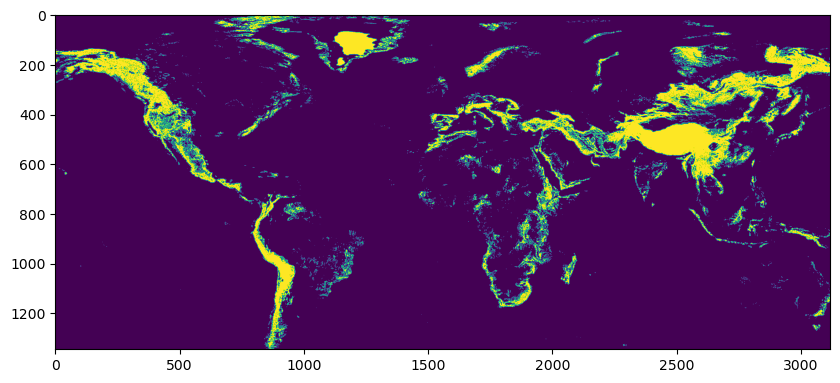

In [13]:
ds_path = "../output/raster_clip.tif"
ds = rasterio.open(ds_path)
plt.figure(figsize=(10, 10))
plt.imshow(ds.read(1))
plt.show()

In [15]:
with fiona.open(sa_path, 'r') as shapefile:
    for feature in shapefile:
        shapes = [feature['geometry']]

In [22]:
raster_clip_fields = mt_ds.rio.clip(shapes)


In [23]:
raster_clip_fields.rio.to_raster("../output/raster_clip.tif")

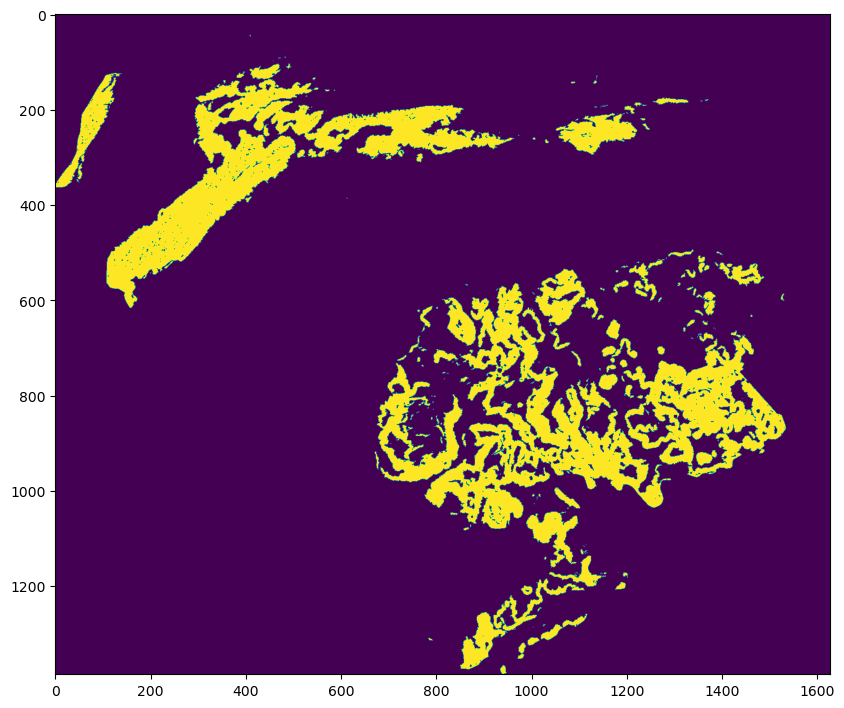

In [24]:
ds_path = "../output/raster_clip.tif"
ds = rasterio.open(ds_path)
plt.figure(figsize=(10, 10))
plt.imshow(ds.read(1))
plt.show()

In [25]:
mt_path = "../data/K3Binary/k3binary.shp"
with fiona.open(mt_path, 'r') as shapefile:
    for feature in shapefile:
        shapes = [feature['geometry']]

AttributeError: 'LineString' object has no attribute 'plot'

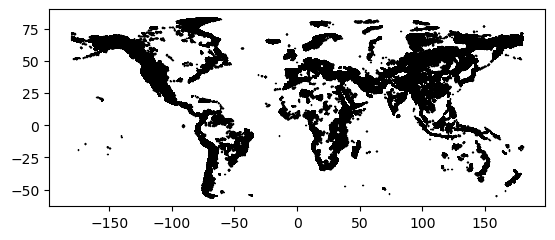

In [28]:
def extract_and_plot_first_geometry(shapefile_path):
    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile_path)

    # Extract the first geometry
    first_geometry = gdf.geometry.iloc[0]

    # Plot the first geometry using geopandas
    ax = gdf.plot(edgecolor='black', facecolor='none')
    first_geometry.boundary.plot(ax=ax, color='red', linewidth=2)

    # Or, if you prefer using matplotlib directly:
    # fig, ax = plt.subplots()
    # gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    # first_geometry.boundary.plot(ax=ax, color='red', linewidth=2)

    plt.show()

# Example usage:
extract_and_plot_first_geometry(mt_path)

In [30]:
gdf = gpd.read_file(mt_path)
gdf.head()

,DN,geometry
0,1,"POLYGON ((-69.69597 83.10819, -69.69181 83.108..."
1,1,"POLYGON ((-74.28139 83.09778, -74.26889 83.097..."
2,1,"POLYGON ((-75.25639 83.03111, -75.24389 83.031..."
3,1,"POLYGON ((-75.27931 83.02486, -75.26889 83.024..."
4,1,"POLYGON ((-76.40222 83.02278, -76.39806 83.022..."


In [3]:
import rioxarray
mountain_path = "../data/GlobalMountainsK3Binary/k1binary.tif"
mt_ds = rioxarray.open_rasterio(mountain_path)
mt_ds

<xarray.DataArray (band: 1, y: 21600, x: 43200)>
[933120000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 90.01 90.0 90.0 89.99 ... -89.96 -89.97 -89.98
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  0
    STATISTICS_MAXIMUM:      1
    STATISTICS_MEAN:         1
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0
    _FillValue:              0
    scale_factor:            1.0
    add_offset:              0.0

In [4]:
dis_path = "../data/HydroRIVERS_v10_shp/raster/reduced_HydroRIVERS_v10.tif"
dis_ds = rioxarray.open_rasterio(dis_path)
dis_ds

<xarray.DataArray (band: 1, y: 1345, x: 3119)>
[4195055 values with dtype=uint64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -159.8 -159.7 -159.6 -159.5 ... 151.8 151.9 152.0
  * y            (y) float64 83.51 83.41 83.31 83.21 ... -50.69 -50.79 -50.89
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [6]:
print("Original Raster:\n----------------\n")
print_raster(mt_ds)
print("Raster to Match:\n----------------\n")
print_raster(dis_ds)

Original Raster:
----------------

shape: (21600, 43200)
resolution: (0.008333333, -0.008333333)
bounds: (-179.999992654, -89.983346888, 179.999992946, 90.016645912)
sum: 105796489
CRS: EPSG:4326

Raster to Match:
----------------

shape: (1345, 3119)
resolution: (0.1, -0.1)
bounds: (-159.83958333333365, -50.93541666666704, 152.06041666666638, 83.56458333333296)
sum: 137711
CRS: EPSG:4326



In [7]:
mt_match =mt_ds.rio.reproject_match(dis_ds)

In [10]:
print("Original Raster:\n----------------\n")
print_raster(dis_ds)
print("Raster to Match:\n----------------\n")
print_raster(mt_match)

Original Raster:
----------------

shape: (1345, 3119)
resolution: (0.1, -0.1)
bounds: (-159.83958333333365, -50.93541666666704, 152.06041666666638, 83.56458333333296)
sum: 137711
CRS: EPSG:4326

Raster to Match:
----------------

shape: (1345, 3119)
resolution: (0.1, -0.1)
bounds: (-159.83958333333365, -50.93541666666704, 152.06041666666638, 83.56458333333296)
sum: 366219
CRS: EPSG:4326



In [12]:
mt_match.values

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

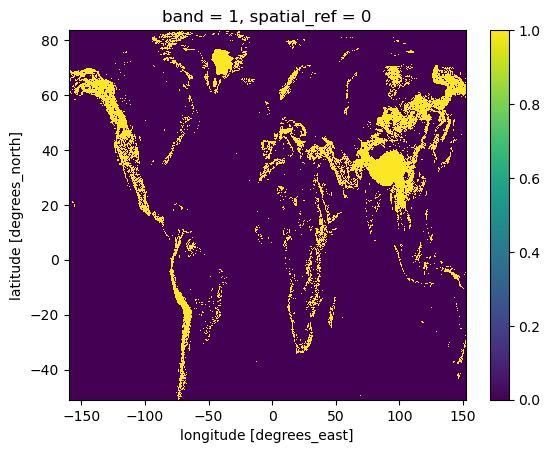

In [16]:
mt_match.plot()

In [14]:
import numpy as np

# Create a new raster array where the value is 1 for mountain regions with non-zero discharge
new_raster_array = np.logical_and(mt_match, dis_ds)

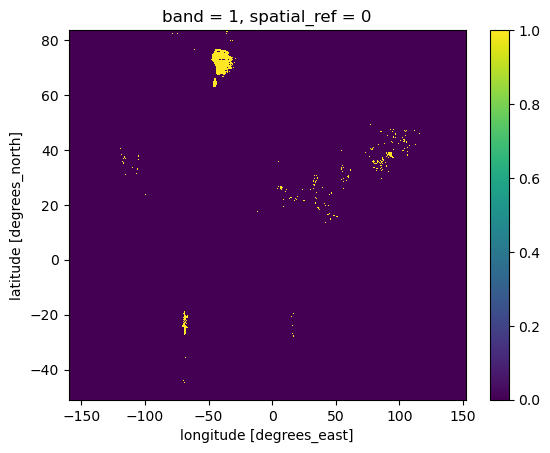

In [17]:
new_raster_array.plot()

In [17]:
import numpy as np

# Assuming raster_array_uint8 is the uint8 array and raster_array_uint64 is the uint64 array
dis_arr = dis_arr.astype(np.uint8)

In [18]:
mt_arr.shape

(21600, 43200)

In [26]:
mt_arr.sum()

105796489

In [30]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

def resample_raster_array(raster_array, target_shape):
    # Assuming raster_array is the original array and target_shape is the shape to resample to

    # Calculate the scale factors for resampling
    scale_x = raster_array.shape[1] / target_shape[1]
    scale_y = raster_array.shape[0] / target_shape[0]

    # Resample the array using rasterio.warp.reproject
    resampled_array = np.empty(target_shape, dtype=raster_array.dtype)
    rasterio.warp.reproject(
        source=raster_array,
        destination=resampled_array,
        src_transform=rasterio.Affine.scale(scale_x, scale_y),
        dst_transform=rasterio.Affine.identity(),
        src_crs='EPSG:4326',  # Replace with the CRS of your original raster
        dst_crs='EPSG:4326',  # Replace with the CRS you want to resample to
        resampling=Resampling.nearest,
    )

    return resampled_array

# Assuming raster_array_mountains is the binary array for mountain regions (0 or 1)
# and raster_array_discharge is the binary array for river discharge (0 or 1)

# Resample one of the arrays to match the shape of the other array
# Choose the target shape based on the shape of the other array
target_shape = mt_arr.shape
dis_arr_resampled = resample_raster_array(dis_arr, target_shape)

# Create a new raster array where the value is 1 for mountain regions with non-zero discharge
new_raster_array = np.logical_and(mt_arr, dis_arr_resampled).astype(np.uint8)


In [31]:
new_raster_array.sum()

0

In [33]:
mt_arr.sum()

105796489

In [34]:
dis_arr.sum()

137711

In [35]:
dis_arr_resampled.sum()

1236